In [1]:
import pandas as pd
import glob

# Define the path to the CSV files
path = 'expanded_data/'  # Update this path to your actual data directory
activities = ['ret', 'lav', 'hoj']
labels = ['ret', 'lav', 'hoj']
all_files = []

# Collect all CSV files for each activity
for activity in activities:
    all_files.extend(glob.glob(path + f"*{activity}*.csv"))  # Match files containing the activity name

# Read all CSV files into a single DataFrame
df_list = []
for filename in all_files:
    # Extract activity name from the filename
    activity_name = [activity for activity in activities if f".{activity}." in filename][0]
    df = pd.read_csv(filename)
    df['activity'] = activity_name  # Assign the activity name
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

In [2]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
from statistics import mode
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Define window size and step size
window_size = 900
step_size = 450

# Initialize lists to store segmented data and labels
x_list = []
y_list = []
z_list = []
pressure_list = []
gyroX_list = []
gyroY_list = []
gyroZ_list = []
train_labels = []

# Segment the data into windows
for i in range(0, df.shape[0] - window_size, step_size):
    xs = df['accX'].values[i: i + window_size]
    ys = df['accY'].values[i: i + window_size]
    zs = df['accZ'].values[i: i + window_size]
    pressures = df['pressure'].values[i: i + window_size]
    gyroXs = df['gyroX'].values[i: i + window_size]
    gyroYs = df['gyroY'].values[i: i + window_size]
    gyroZs = df['gyroZ'].values[i: i + window_size] 
    label = mode(df['activity'][i: i + window_size])
    
    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    pressure_list.append(pressures)
    gyroX_list.append(gyroXs)
    gyroY_list.append(gyroYs)
    gyroZ_list.append(gyroZs)
    train_labels.append(label)

In [3]:
import pandas as pd
import glob

# Define the path to the CSV files
path = 'expanded_data/'  # Update this path to your actual data directory
activities = ['ret', 'lav', 'hoj']
dfs_train = []
dfs_test = []

# Read the CSV files and split each into train and test sets
for activity in activities:
    files = glob.glob(path + f"*{activity}*.csv")  # Match the naming pattern
    for filename in files:
        df = pd.read_csv(filename)
        df['activity'] = activity  # Assign the activity based on the loop variable
        
        # Split the data: first two-thirds for training, last one-third for testing
        split_index = int(len(df) * 2 / 3)
        dfs_train.append(df[:split_index])
        dfs_test.append(df[split_index:])

# Combine all training and testing data
df_train = pd.concat(dfs_train, ignore_index=True)
df_test = pd.concat(dfs_test, ignore_index=True)

# Verify the splits
print("Train data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

Train data shape: (147678, 9)
Test data shape: (73845, 9)


In [4]:
x_list = []
y_list = []
z_list = []
pressure_list = []
gyroX_list = []
gyroY_list = []
gyroZ_list = []
train_labels = []

window_size = 900
step_size = 450

# creating overlaping windows of size window-size 900 and step size 450
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['accX'].values[i: i + window_size]
    ys = df_train['accY'].values[i: i + window_size]
    zs = df_train['accZ'].values[i: i + window_size]
    pressures = df_train['pressure'].values[i: i + window_size]
    gyroXs = df_train['gyroX'].values[i: i + window_size]
    gyroYs = df_train['gyroY'].values[i: i + window_size]
    gyroZs = df_train['gyroZ'].values[i: i + window_size]
    label = df_train['activity'][i: i + window_size].mode()[0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    pressure_list.append(pressures)
    gyroX_list.append(gyroXs)
    gyroY_list.append(gyroYs)
    gyroZ_list.append(gyroZs)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())
X_train['pressure_mean'] = pd.Series(pressure_list).apply(lambda x: x.mean())
X_train['gyroY_mean'] = pd.Series(gyroY_list).apply(lambda x: x.mean())
X_train['gyroZ_mean'] = pd.Series(gyroZ_list).apply(lambda x: x.mean())

# min
X_train['pressure_min'] = pd.Series(pressure_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())

# max
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['pressure_max'] = pd.Series(pressure_list).apply(lambda x: x.max())

# median
X_train['pressure_median'] = pd.Series(pressure_list).apply(lambda x: np.median(x))

# energy
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/window_size)
X_train['pressure_energy'] = pd.Series(pressure_list).apply(lambda x: np.sum(x**2)/window_size)

# Custom ratios
X_train['acc_gyro_ratio_y'] = X_train['y_mean'] / (X_train['gyroY_mean'] + 1e-6)
X_train['acc_gyro_ratio_z'] = X_train['z_mean'] / (X_train['gyroZ_mean'] + 1e-6)

In [5]:
x_list = []
y_list = []
z_list = []
pressure_list = []
gyroX_list = []
gyroY_list = []
gyroZ_list = []
test_labels = []

window_size = 900
step_size = 450

# creating overlaping windows of size window-size 900 and step size 450
for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['accX'].values[i: i + window_size]
    ys = df_test['accY'].values[i: i + window_size]
    zs = df_test['accZ'].values[i: i + window_size]
    pressures = df_test['pressure'].values[i: i + window_size]
    gyroXs = df_test['gyroX'].values[i: i + window_size]
    gyroYs = df_test['gyroY'].values[i: i + window_size]
    gyroZs = df_test['gyroZ'].values[i: i + window_size]
    label = df_test['activity'][i: i + window_size].mode()[0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    pressure_list.append(pressures)
    gyroX_list.append(gyroXs)
    gyroY_list.append(gyroYs)
    gyroZ_list.append(gyroZs)
    test_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

# mean
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())
X_test['pressure_mean'] = pd.Series(pressure_list).apply(lambda x: x.mean())
X_test['gyroY_mean'] = pd.Series(gyroY_list).apply(lambda x: x.mean())
X_test['gyroZ_mean'] = pd.Series(gyroZ_list).apply(lambda x: x.mean())

# min
X_test['pressure_min'] = pd.Series(pressure_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())

# max
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['pressure_max'] = pd.Series(pressure_list).apply(lambda x: x.max())

# median
X_test['pressure_median'] = pd.Series(pressure_list).apply(lambda x: np.median(x))

# energy
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/window_size)
X_test['pressure_energy'] = pd.Series(pressure_list).apply(lambda x: np.sum(x**2)/window_size)

# Custom ratios
X_test['acc_gyro_ratio_y'] = X_test['y_mean'] / (X_test['gyroY_mean'] + 1e-6)
X_test['acc_gyro_ratio_z'] = X_test['z_mean'] / (X_test['gyroZ_mean'] + 1e-6)

In [6]:
# Verify the splits
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (327, 14)
Test data shape: (163, 14)


In [7]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [8]:
print("Class distribution in y_train:", pd.Series(y_train).value_counts())

Class distribution in y_train: ret    113
lav    109
hoj    105
Name: count, dtype: int64


In [9]:
from sklearn.impute import SimpleImputer

# Verify that there are no NaN values
print("NaN in X_train before imputation:", X_train.isnull().sum().sum())
print("NaN in X_test before imputation:", X_test.isnull().sum().sum())

# Replace missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify that there are no NaN values
print("NaN in X_train after imputation:", X_train.isnull().sum().sum())
print("NaN in X_test after imputation:", X_test.isnull().sum().sum())

NaN in X_train before imputation: 0
NaN in X_test before imputation: 0
NaN in X_train after imputation: 0
NaN in X_test after imputation: 0


In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame if needed
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

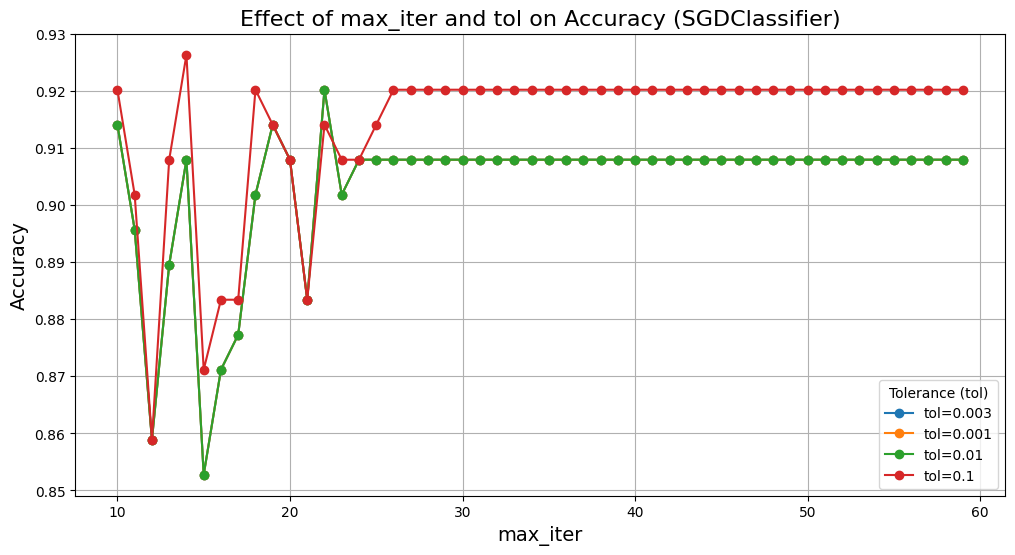

Best Accuracy: 0.9263803680981595
Best Parameters: {'max_iter': 14, 'tol': 0.1}


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Define ranges for max_iter and tol
max_iter_values = range(10, 60)  # Test max_iter from 10 to 200 in steps of 10
tol_values = [0.003 ,1e-3, 1e-2, 1e-1]

# Initialize variables to store results
results = []
best_accuracy = 0
best_params = {}

# Perform grid search
for max_iter in max_iter_values:
    for tol in tol_values:
        sgd = SGDClassifier(random_state=21, max_iter=max_iter, tol=tol)
        sgd.fit(X_train, y_train)
        y_pred = sgd.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((max_iter, tol, acc))
        
        # Update best parameters if current accuracy is better
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {'max_iter': max_iter, 'tol': tol}

# Convert results to a structured array for plotting
results_array = np.array(results, dtype=[('max_iter', int), ('tol', float), ('accuracy', float)])

# Plot results
plt.figure(figsize=(12, 6))
for tol in tol_values:
    subset = results_array[results_array['tol'] == tol]
    if len(subset) > 0:  # Ensure there are results for this tol
        plt.plot(subset['max_iter'], subset['accuracy'], marker='o', label=f"tol={tol}")

plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of max_iter and tol on Accuracy (SGDClassifier)', fontsize=16)
plt.legend(title="Tolerance (tol)")
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9263803680981595

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.91      1.00      0.95        52
         lav       0.91      0.96      0.94        55
         ret       0.96      0.82      0.88        56

    accuracy                           0.93       163
   macro avg       0.93      0.93      0.93       163
weighted avg       0.93      0.93      0.92       163



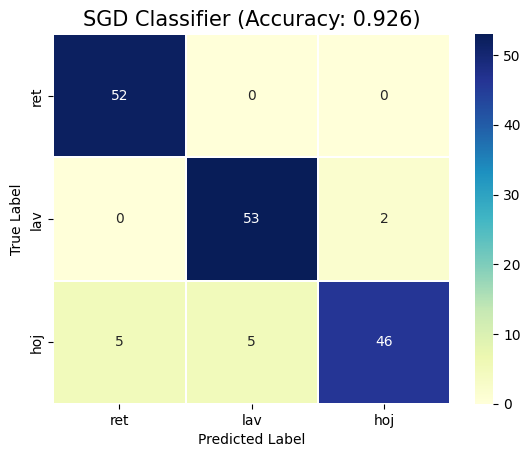

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the SGDClassifier
sgd = SGDClassifier(random_state=21, max_iter=14, tol=0.1)
sgd.fit(X_train, y_train)

# Make predictions
y_pred = sgd.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SGD Classifier (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

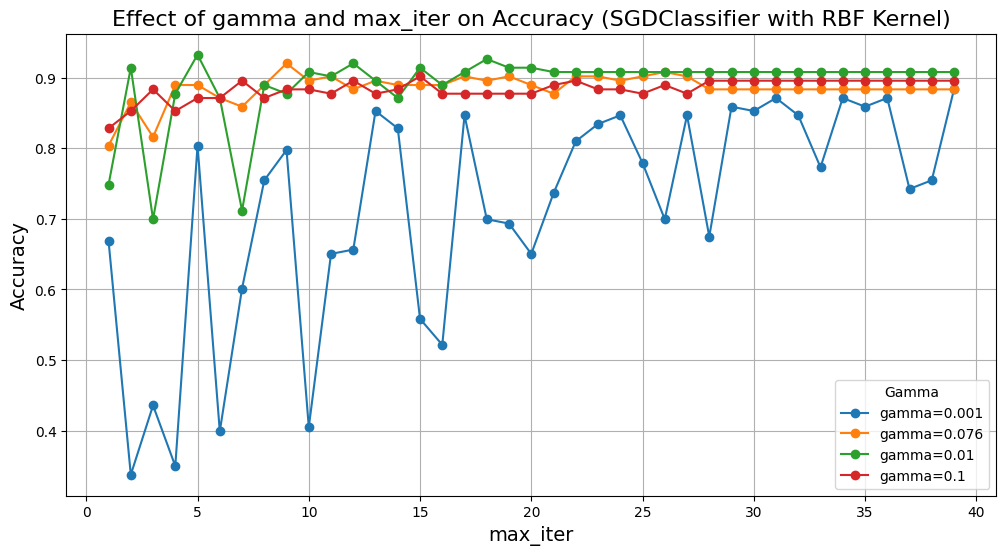

Best Accuracy: 0.9325153374233128
Best Parameters: {'gamma': 0.01, 'max_iter': 5}


In [13]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define ranges for gamma and max_iter
gamma_values = [0.001, 0.076, 0.01, 0.1]  # Adjust as needed
max_iter_values = range(1, 40)  # Adjust as needed

# Initialize variables to store results
results = []
best_accuracy = 0
best_params = {}

# Perform grid search
for gamma in gamma_values:
    # Apply RBF kernel approximation with the current gamma
    rbf_feature = RBFSampler(gamma=gamma, random_state=21)
    X_train_rbf = rbf_feature.fit_transform(X_train)
    X_test_rbf = rbf_feature.transform(X_test)
    
    for max_iter in max_iter_values:
        # Train the SGDClassifier with the current max_iter
        sgd = SGDClassifier(random_state=21, max_iter=max_iter, tol=1e-3)
        sgd.fit(X_train_rbf, y_train)
        y_pred = sgd.predict(X_test_rbf)
        acc = accuracy_score(y_test, y_pred)
        
        # Store the results
        results.append((gamma, max_iter, acc))
        
        # Update best parameters if current accuracy is better
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {'gamma': gamma, 'max_iter': max_iter}

# Convert results to a structured array for plotting
results_array = np.array(results, dtype=[('gamma', float), ('max_iter', int), ('accuracy', float)])

# Plot results
plt.figure(figsize=(12, 6))
for gamma in gamma_values:
    subset = results_array[results_array['gamma'] == gamma]
    plt.plot(subset['max_iter'], subset['accuracy'], marker='o', label=f"gamma={gamma}")

plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of gamma and max_iter on Accuracy (SGDClassifier with RBF Kernel)', fontsize=16)
plt.legend(title="Gamma")
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9325153374233128

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       1.00      0.98      0.99        52
         lav       0.94      0.85      0.90        55
         ret       0.87      0.96      0.92        56

    accuracy                           0.93       163
   macro avg       0.94      0.93      0.93       163
weighted avg       0.94      0.93      0.93       163



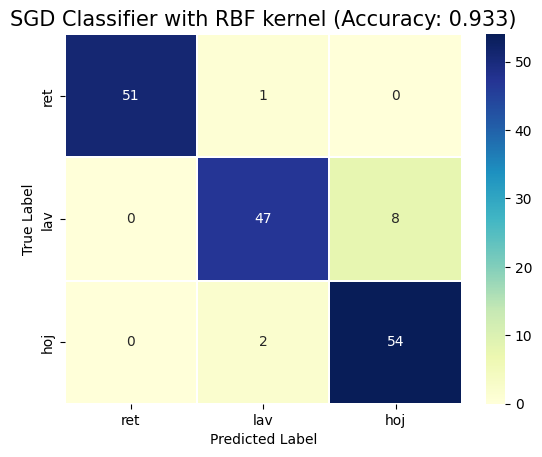

In [37]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Apply RBF kernel approximation
rbf_feature = RBFSampler(gamma=0.01, random_state=21)  # Adjust gamma as needed
X_train_rbf = rbf_feature.fit_transform(X_train)
X_test_rbf = rbf_feature.transform(X_test)

# Train the SGDClassifier with kernel-approximated features
sgd = SGDClassifier(random_state=21, max_iter=5, tol=1e-3)
sgd.fit(X_train_rbf, y_train)

# Make predictions
y_pred = sgd.predict(X_test_rbf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SGD Classifier with RBF kernel (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

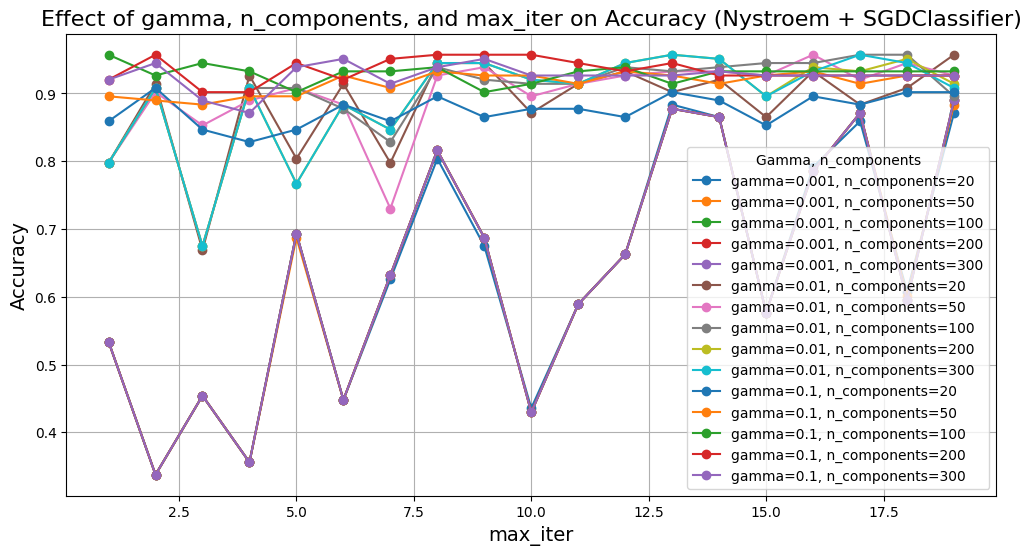

Best Accuracy: 0.9570552147239264
Best Parameters: {'gamma': 0.01, 'n_components': 20, 'max_iter': 19}


In [15]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define ranges for gamma, n_components, and max_iter
gamma_values = [0.001, 0.01, 0.1]  # Adjust as needed
n_components_values = [20, 50, 100, 200, 300]  # Adjust as needed
max_iter_values = range(1, 20)  # Adjust as needed

# Initialize variables to store results
results = []
best_accuracy = 0
best_params = {}

# Perform grid search
for gamma in gamma_values:
    for n_components in n_components_values:
        # Apply Nystroem kernel approximation with the current gamma and n_components
        nystroem_feature = Nystroem(kernel='rbf', gamma=gamma, random_state=21, n_components=n_components)
        X_train_nystroem = nystroem_feature.fit_transform(X_train)
        X_test_nystroem = nystroem_feature.transform(X_test)
        
        for max_iter in max_iter_values:
            # Train the SGDClassifier with the current max_iter
            sgd = SGDClassifier(random_state=21, max_iter=max_iter, tol=1e-3)
            sgd.fit(X_train_nystroem, y_train)
            y_pred = sgd.predict(X_test_nystroem)
            acc = accuracy_score(y_test, y_pred)
            
            # Store the results
            results.append((gamma, n_components, max_iter, acc))
            
            # Update best parameters if current accuracy is better
            if acc > best_accuracy:
                best_accuracy = acc
                best_params = {'gamma': gamma, 'n_components': n_components, 'max_iter': max_iter}

# Convert results to a structured array for plotting
results_array = np.array(results, dtype=[('gamma', float), ('n_components', int), ('max_iter', int), ('accuracy', float)])

# Plot results for each gamma value
plt.figure(figsize=(12, 6))
for gamma in gamma_values:
    subset = results_array[results_array['gamma'] == gamma]
    for n_components in n_components_values:
        sub_subset = subset[subset['n_components'] == n_components]
        plt.plot(sub_subset['max_iter'], sub_subset['accuracy'], marker='o', label=f"gamma={gamma}, n_components={n_components}")

plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of gamma, n_components, and max_iter on Accuracy (Nystroem + SGDClassifier)', fontsize=16)
plt.legend(title="Gamma, n_components")
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9570552147239264

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       1.00      1.00      1.00        52
         lav       0.91      0.96      0.94        55
         ret       0.96      0.91      0.94        56

    accuracy                           0.96       163
   macro avg       0.96      0.96      0.96       163
weighted avg       0.96      0.96      0.96       163



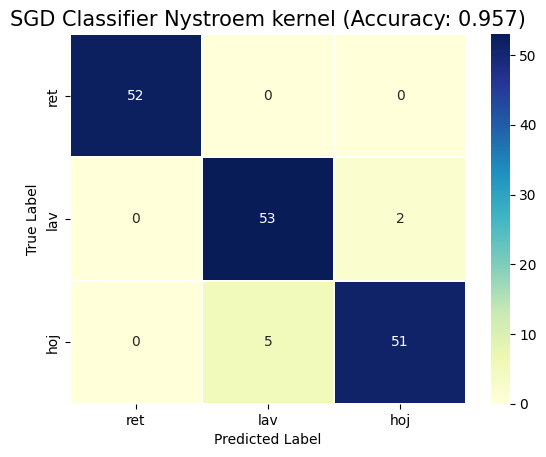

In [38]:
from sklearn.kernel_approximation import Nystroem

# Apply Nystroem kernel approximation
nystroem_feature = Nystroem(kernel='rbf', gamma=0.01, random_state=21, n_components=20)  # Adjust gamma and n_components
X_train_nystroem = nystroem_feature.fit_transform(X_train)
X_test_nystroem = nystroem_feature.transform(X_test)

# Train the SGDClassifier with kernel-approximated features
sgd = SGDClassifier(random_state=21, max_iter=19, tol=1e-3)
sgd.fit(X_train_nystroem, y_train)

# Make predictions
y_pred = sgd.predict(X_test_nystroem)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SGD Classifier Nystroem kernel (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

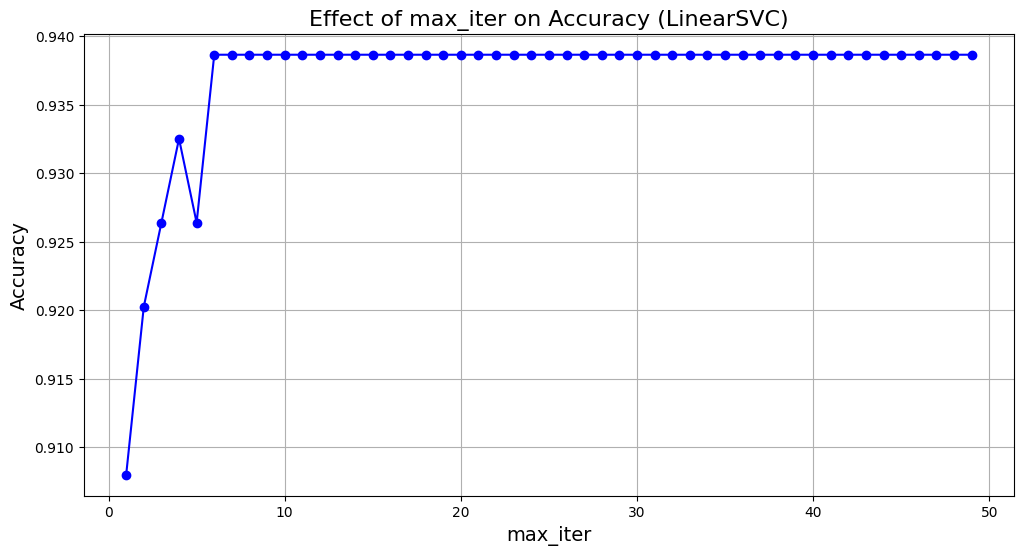

Best Accuracy: 0.9386503067484663
Best Parameters: {'max_iter': 6}


In [17]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Define a range of max_iter values to test
max_iter_values = range(1, 50)  # Testing max_iter from 1 to 200
accuracies = []

# Initialize variables to track the best accuracy and parameters
best_accuracy = 0
best_params = {}

# Loop through each max_iter value
for max_iter in max_iter_values:
    svc = LinearSVC(random_state=21, max_iter=max_iter)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Update best accuracy and parameters if current accuracy is better
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'max_iter': max_iter}

# Plot max_iter vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of max_iter on Accuracy (LinearSVC)', fontsize=16)
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9386503067484663

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.93      1.00      0.96        52
         lav       0.98      0.91      0.94        55
         ret       0.91      0.91      0.91        56

    accuracy                           0.94       163
   macro avg       0.94      0.94      0.94       163
weighted avg       0.94      0.94      0.94       163



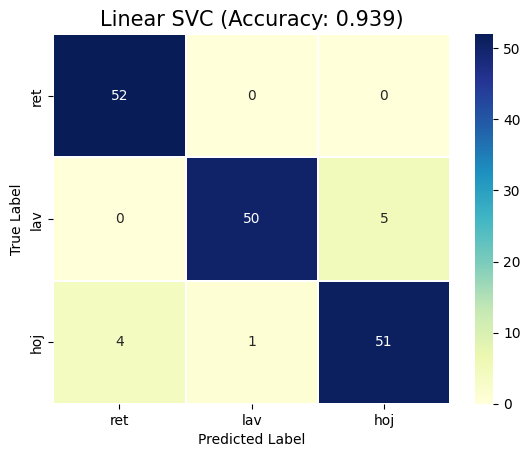

In [39]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the LinearSVC
svc = LinearSVC(random_state=21, max_iter=6)
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"Linear SVC (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

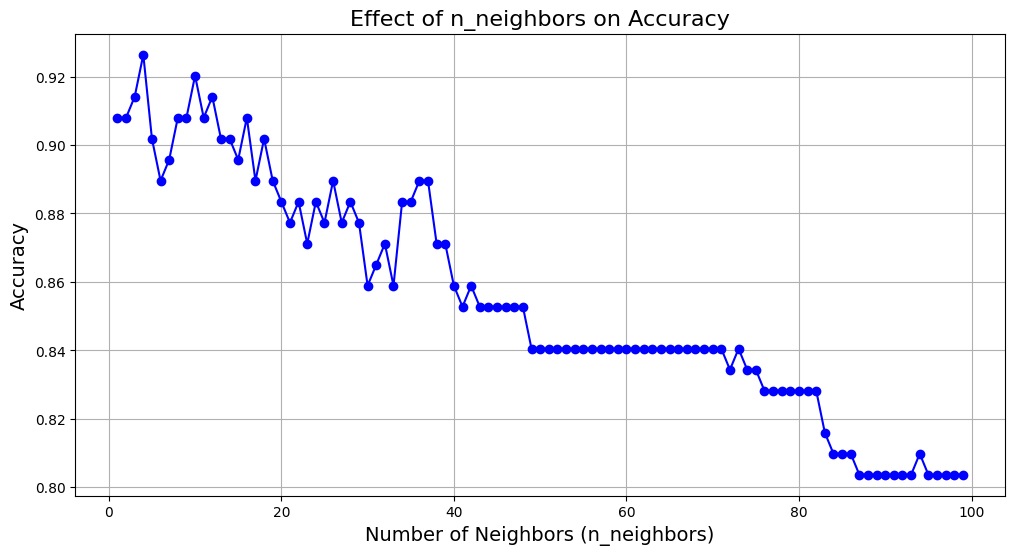

Best Accuracy: 0.9263803680981595
Best Parameters: {'n_neighbors': 4}


In [19]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define a range of n_neighbors values to test
n_neighbors_values = range(1, 100)  # Testing n_neighbors from 1 to 20
accuracies = []

# Initialize variables to track the best accuracy and parameters
best_accuracy = 0
best_params = {}

# Loop through each n_neighbors value
for n_neighbors in n_neighbors_values:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Update best accuracy and parameters if current accuracy is better
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'n_neighbors': n_neighbors}

# Plot n_neighbors vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(n_neighbors_values, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (n_neighbors)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of n_neighbors on Accuracy', fontsize=16)
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9263803680981595

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.93      0.98      0.95        52
         lav       0.94      0.89      0.92        55
         ret       0.91      0.91      0.91        56

    accuracy                           0.93       163
   macro avg       0.93      0.93      0.93       163
weighted avg       0.93      0.93      0.93       163



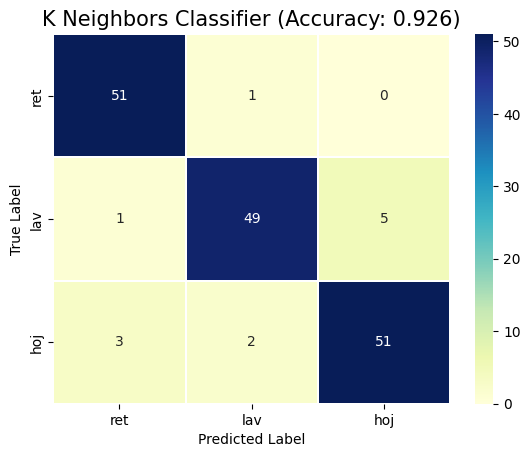

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)  # You can adjust n_neighbors as needed
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"K Neighbors Classifier (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

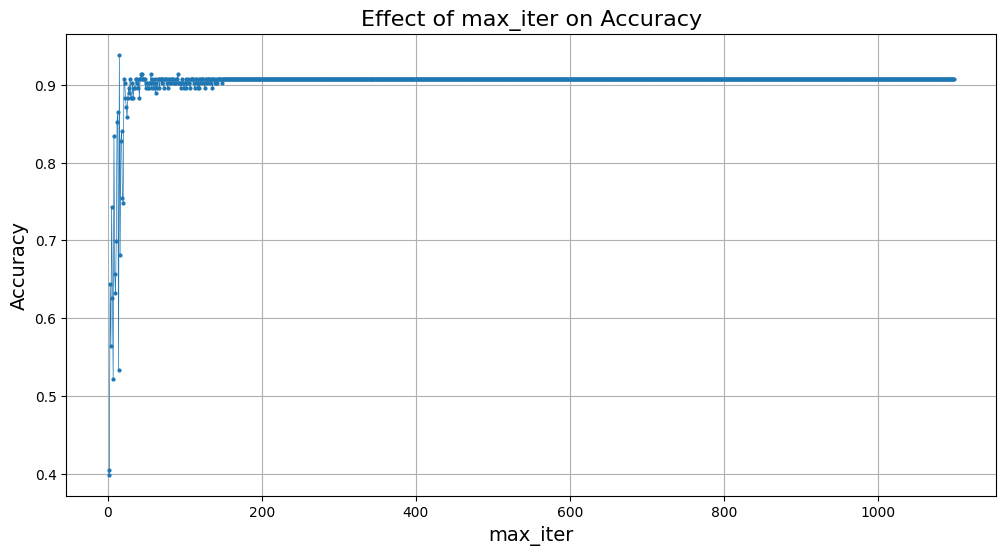

Best Accuracy: 0.9386503067484663
Best Parameters: {'max_iter': 15}


In [21]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of max_iter values from 1 to 1000 with an increment of 1
max_iter_values = range(1, 1100)  # 1 to 1000 inclusive
accuracies = []

# Initialize variables to track the best accuracy and parameters
best_accuracy = 0
best_params = {}

# Loop through each max_iter value
for max_iter in max_iter_values:
    svc = SVC(kernel='linear', random_state=21, max_iter=max_iter)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Update best accuracy and parameters if current accuracy is better
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'max_iter': max_iter}

# Plot max_iter vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(max_iter_values, accuracies, marker='o', markersize=2, linestyle='-', linewidth=0.5)
plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of max_iter on Accuracy', fontsize=16)
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9386503067484663

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.93      1.00      0.96        52
         lav       0.92      0.98      0.95        55
         ret       0.98      0.84      0.90        56

    accuracy                           0.94       163
   macro avg       0.94      0.94      0.94       163
weighted avg       0.94      0.94      0.94       163



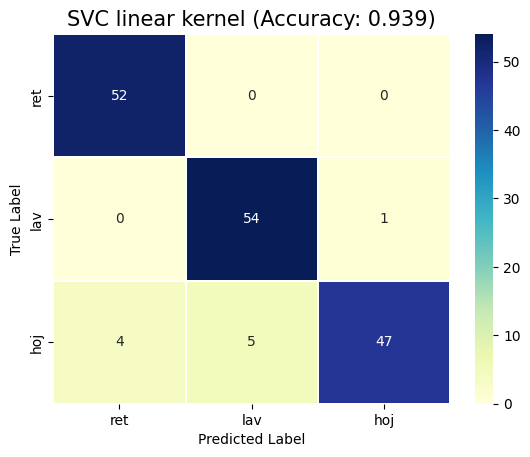

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svc = SVC(kernel='linear', random_state=21, max_iter=15)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SVC linear kernel (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

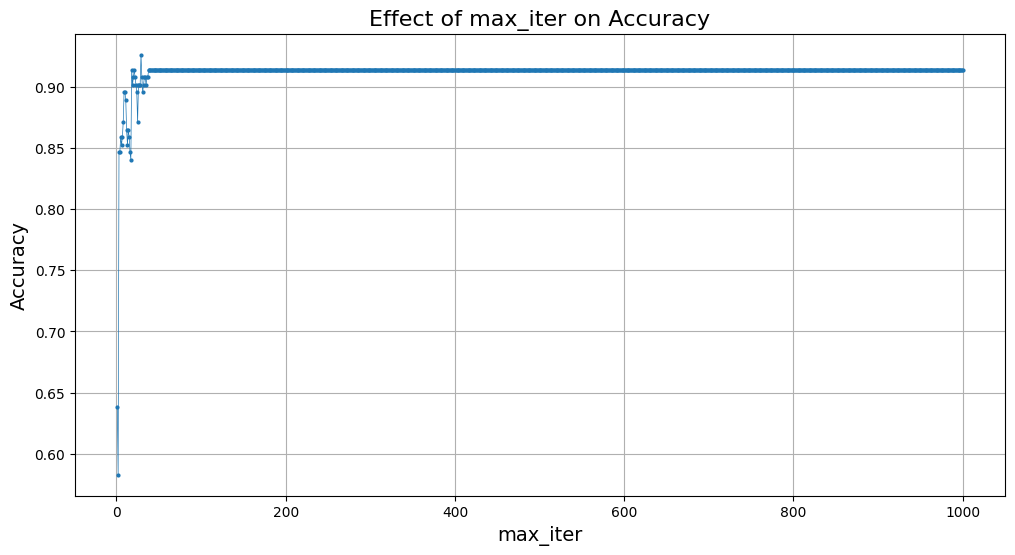

Best Accuracy: 0.9263803680981595
Best Parameters: {'max_iter': 29}


In [23]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of max_iter values from 1 to 1500 with an increment of 1
max_iter_values = range(1, 1001)  # 1 to 1500 inclusive
accuracies = []

# Initialize variables to track the best accuracy and parameters
best_accuracy = 0
best_params = {}

# Loop through each max_iter value
for max_iter in max_iter_values:
    svc = SVC(kernel='rbf', random_state=21, max_iter=max_iter)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Update best accuracy and parameters if current accuracy is better
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'max_iter': max_iter}

# Plot max_iter vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(max_iter_values, accuracies, marker='o', markersize=2, linestyle='-', linewidth=0.5)
plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of max_iter on Accuracy', fontsize=16)
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9263803680981595

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       1.00      1.00      1.00        52
         lav       0.96      0.82      0.88        55
         ret       0.84      0.96      0.90        56

    accuracy                           0.93       163
   macro avg       0.93      0.93      0.93       163
weighted avg       0.93      0.93      0.93       163



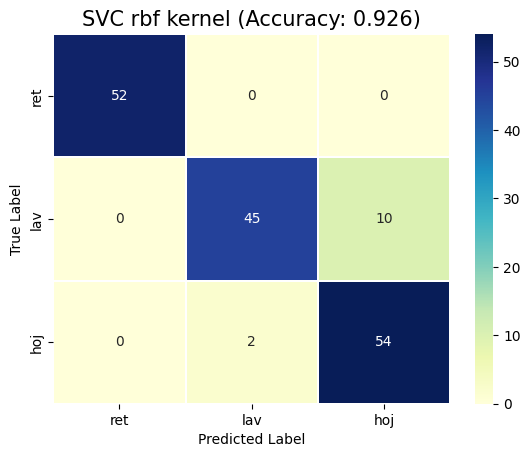

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svc = SVC(kernel='rbf', random_state=21, max_iter=29)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SVC rbf kernel (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

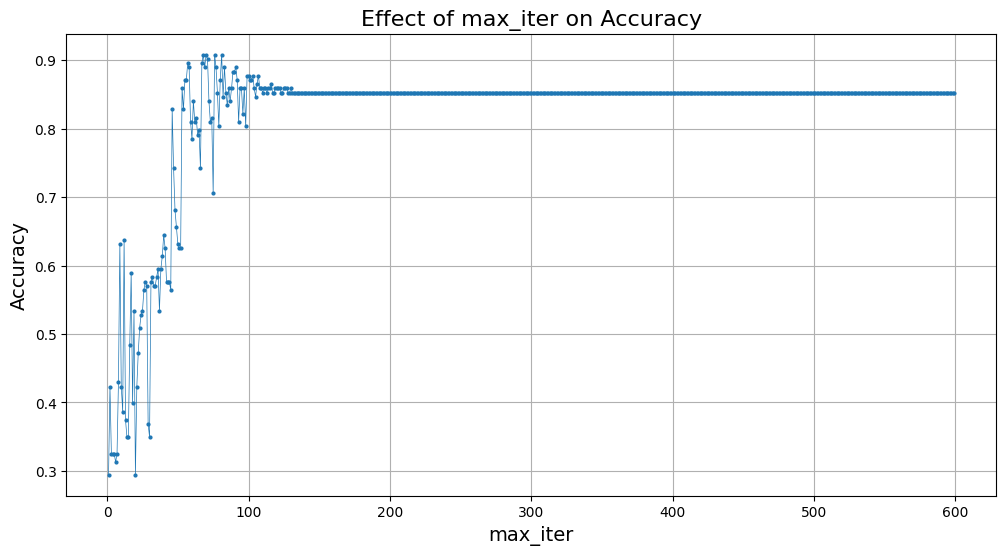

Best Accuracy: 0.9079754601226994
Best Parameters: {'max_iter': 68}


In [25]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of max_iter values from 1 to 100000 with an increment of 1
max_iter_values = range(1, 600)  # 1 to 100000 inclusive
accuracies = []

# Initialize variables to track the best accuracy and parameters
best_accuracy = 0
best_params = {}

# Loop through each max_iter value
for max_iter in max_iter_values:
    svc = SVC(kernel='poly', random_state=21, max_iter=max_iter)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Update best accuracy and parameters if current accuracy is better
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'max_iter': max_iter}

# Plot max_iter vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(max_iter_values, accuracies, marker='o', markersize=2, linestyle='-', linewidth=0.5)
plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of max_iter on Accuracy', fontsize=16)
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.9079754601226994

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.87      1.00      0.93        52
         lav       0.98      0.89      0.93        55
         ret       0.89      0.84      0.86        56

    accuracy                           0.91       163
   macro avg       0.91      0.91      0.91       163
weighted avg       0.91      0.91      0.91       163



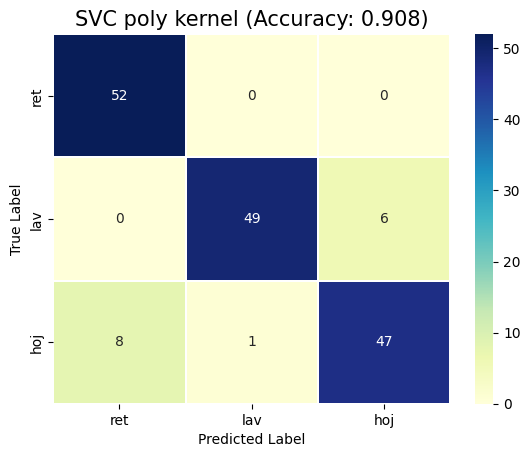

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svc = SVC(kernel='poly', random_state=21, max_iter=68)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SVC poly kernel (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

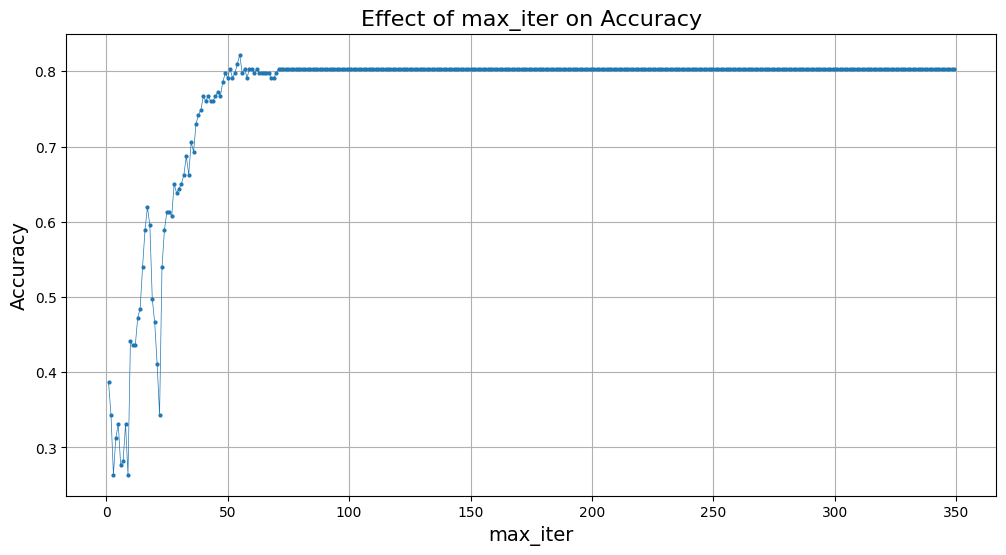

Best Accuracy: 0.8220858895705522
Best Parameters: {'max_iter': 55}


In [27]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of max_iter values from 1 to 1000 with an increment of 1
max_iter_values = range(1, 350)  # 1 to 1000 inclusive
accuracies = []

# Initialize variables to track the best accuracy and parameters
best_accuracy = 0
best_params = {}

# Loop through each max_iter value
for max_iter in max_iter_values:
    svc = SVC(kernel='sigmoid', random_state=21, max_iter=max_iter)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Update best accuracy and parameters if current accuracy is better
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'max_iter': max_iter}

# Plot max_iter vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(max_iter_values, accuracies, marker='o', markersize=2, linestyle='-', linewidth=0.5)
plt.xlabel('max_iter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of max_iter on Accuracy', fontsize=16)
plt.grid(True)
plt.show()

# Print the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Accuracy: 0.8220858895705522

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.76      0.92      0.83        52
         lav       0.81      0.85      0.83        55
         ret       0.93      0.70      0.80        56

    accuracy                           0.82       163
   macro avg       0.83      0.82      0.82       163
weighted avg       0.84      0.82      0.82       163



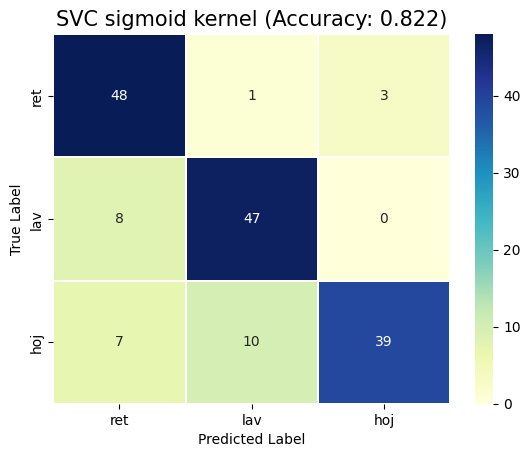

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svc = SVC(kernel='sigmoid', random_state=21, max_iter=55)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"SVC sigmoid kernel (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy: 0.9079754601226994

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       0.90      1.00      0.95        52
         lav       0.93      0.91      0.92        55
         ret       0.90      0.82      0.86        56

    accuracy                           0.91       163
   macro avg       0.91      0.91      0.91       163
weighted avg       0.91      0.91      0.91       163



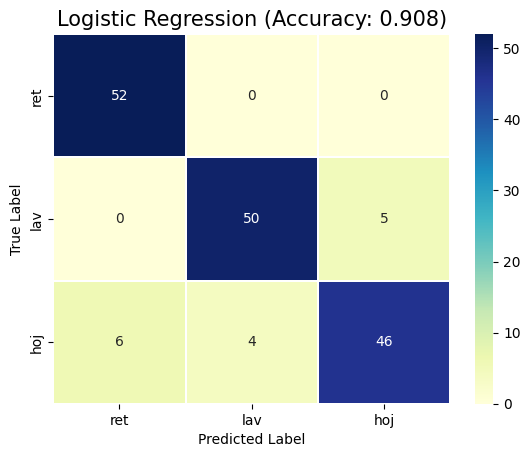

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

lr = LogisticRegression(random_state=21)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"Logistic Regression (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': range(1, 20),
    'max_depth': range(1,50),
    'max_features': ['sqrt', 'log2']
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=21)

# Set up GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1862 candidates, totalling 5586 fits
Best parameters found: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 13}
Best cross-validation accuracy: 0.8715596330275229
Test Accuracy: 0.8957055214723927

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       1.00      1.00      1.00        52
         lav       0.76      1.00      0.87        55
         ret       1.00      0.70      0.82        56

    accuracy                           0.90       163
   macro avg       0.92      0.90      0.90       163
weighted avg       0.92      0.90      0.89       163



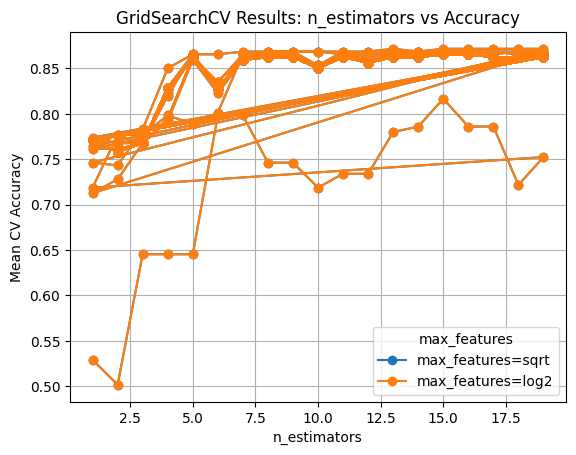

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert cv_results_ to a DataFrame for easier plotting
results_df = pd.DataFrame(grid_search.cv_results_)

# Example: Plot mean test score vs n_estimators for each max_features
for max_feat in results_df['param_max_features'].unique():
    subset = results_df[results_df['param_max_features'] == max_feat]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], marker='o', label=f"max_features={max_feat}")

plt.xlabel('n_estimators')
plt.ylabel('Mean CV Accuracy')
plt.title('GridSearchCV Results: n_estimators vs Accuracy')
plt.legend(title='max_features')
plt.grid(True)
plt.show()

Accuracy: 0.8957055214723927

 -------------Classification Report-------------

              precision    recall  f1-score   support

         hoj       1.00      1.00      1.00        52
         lav       0.76      1.00      0.87        55
         ret       1.00      0.70      0.82        56

    accuracy                           0.90       163
   macro avg       0.92      0.90      0.90       163
weighted avg       0.92      0.90      0.89       163



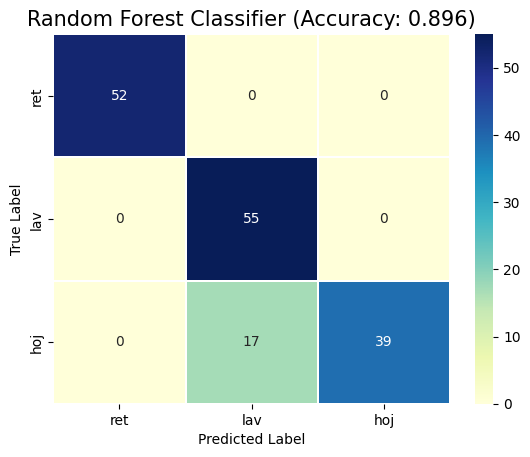

In [46]:
#lets try random forrest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=13, random_state = 21)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt="d", cmap='YlGnBu')
plt.title(f"Random Forest Classifier (Accuracy: {accuracy:.3f})", fontsize=15)  # Add accuracy to the title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [51]:
# get most dewxriptive features in rf
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances 

# Save feature_importances to a CSV file
feature_importances.to_csv('feature_importances_after_top_10.csv', index=True)

print("Feature importances saved to 'feature_importances.csv'")

Feature importances saved to 'feature_importances.csv'


In [52]:
feature_importances.head(14)

,importance
y_energy,0.226410
pressure_mean,0.198959
pressure_median,0.183068
y_max,0.125127
pressure_energy,0.086419
acc_gyro_ratio_y,0.082792
y_mean,0.052439
pressure_min,0.040433
z_mean,0.004353
gyroY_mean,0.000000
